In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# graphalytics inserts
pers_experiments = "num_threads_read == 0 and (hostname == 'scyper21' or hostname == 'scyper22')"

data_ins = common.import_gfe("view_graphalytics_inserts").query(pers_experiments).copy() # data from the experiments
data_ins["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data_ins = data_ins.query("((block_size == 512) and library == 'sortledton') or library != 'sortledton'")
data_ins = data_ins.query("(library == 'llama8-ref' and build_frequency == '0:0:10') or library != 'llama8-ref'")

# graphalytics load
data_load = common.import_gfe("view_graphalytics_load").query(pers_experiments).copy()
# shape the dataframe as data_ins
data_load["build_frequency"] = pd.Timedelta(0)
data_load["build_frequency_secs"] = np.NaN
data_load["num_snapshots_created"] = 0
data_load["num_threads_write"] = 0
data_load["block_size"] = -1

data = pd.concat([data_ins, data_load])
data = data.query("graph == 'graph500-24'")

rename_libraries = {
    "csr3": "CSR",
    "sortledton": "Sortledton",
    "llama8-ref": "LLama",
    "csr3-lcc": "CSR-LCC",
    "g1_v6-ref-ignore-build": "G1",
    "livegraph3_ro": "Livegraph",
    "stinger7-ref": "Stinger",
    "teseo-lcc.12": "Teseo",
    "teseo-lcc-dv.12b": "Teseo dense"
}

data["library"] = data["library"].map(lambda l: rename_libraries[l] if l in rename_libraries  else l)


data = data.groupby(["library", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"))


data = data.unstack("algorithm")[("completion_time")]
data["bfs_speedup"] = data["bfs"] / data.loc["CSR"]["bfs"]
data["pagerank_speedup"] = data["pagerank"] / data.loc["CSR"]["pagerank"]
data["wcc_speedup"] = data["wcc"] / data.loc["CSR"]["wcc"]
data["sssp_speedup"] = data["sssp"] / data.loc["CSR"]["sssp"]
data["lcc_speedup"] = data["lcc"] / data.loc["CSR-LCC"]["lcc"]

data = data.drop(["bfs", "cdlp", "pagerank", "sssp", "wcc", "lcc"], axis=1)

data.index.set_names("Library", inplace=True)
data.columns.set_names("Algorithm", inplace=True)
data

Algorithm,bfs_speedup,pagerank_speedup,wcc_speedup,sssp_speedup,lcc_speedup
Library,,,,,
CSR,1.000000,1.000000,1.000000,1.000000,27.789488
CSR-LCC,1.000436,0.998808,0.983582,0.814671,1.000000
G1,26.686480,3.340110,68.411627,2.272889,NaN
LLama,1.206337,1.203598,0.895930,3.762121,NaN
Livegraph,15.874334,2.595364,1.787183,1.368186,43.979971
Sortledton,3.028294,0.834468,0.670480,0.887192,2.811211
Stinger,3.710774,2.474664,2.985582,1.390010,NaN
Teseo,1.321092,3.205156,4.376726,2.206666,5.228757
Teseo dense,1.440989,0.868403,0.925249,0.831698,1.894244


In [3]:
path = "/home/per/workspace/sortledton-presentation/figures/"

## General analytics

<AxesSubplot:title={'center':'GAP Benchmark Suite on Graph500-24'}, xlabel='Data Structures', ylabel='Slowdown compared to CSR'>

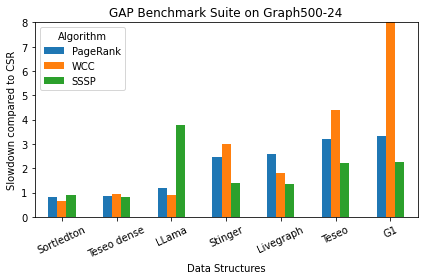

In [4]:
data_an = data.drop("bfs_speedup", axis=1)
data_an = data_an.drop("CSR-LCC")
data_an = data_an.drop("CSR")
data_an = data_an.drop("csr3-lcc-numa")
data_an = data_an.sort_values("pagerank_speedup")
data_an["PageRank"] = data_an["pagerank_speedup"]
data_an["WCC"] = data_an["wcc_speedup"]
data_an["SSSP"] = data_an["sssp_speedup"]
data_an = data_an.drop("pagerank_speedup", axis=1)
data_an = data_an.drop("wcc_speedup", axis=1)
data_an = data_an.drop("sssp_speedup", axis=1)
data_an = data_an.drop("lcc_speedup", axis=1)

p = data_an.plot.bar()

plt.xlabel("Data Structures")
plt.ylabel("Slowdown compared to CSR")
plt.ylim(0, 8)
plt.xticks(rotation=25)
plt.title("GAP Benchmark Suite on Graph500-24")

plt.tight_layout()
plt.savefig(path + "analytical_performance.png")
#p.get_legend().remove()

p

## LCC

In [5]:
data_lcc = data.drop("pagerank_speedup", axis=1)
data_lcc = data_lcc.drop("wcc_speedup", axis=1)
data_lcc = data_lcc.drop("bfs_speedup", axis=1)
data_lcc = data_lcc.drop("sssp_speedup", axis=1)
data_lcc = data_lcc.drop("CSR")
data_lcc = data_lcc.sort_values("lcc_speedup")
data_lcc = data_lcc.drop("G1")
data_lcc = data_lcc.drop("LLama")
data_lcc = data_lcc.drop("Stinger")
data_lcc = data_lcc.drop("csr3-lcc-numa")
data_lcc = data_lcc.drop("CSR-LCC")

data_lcc

Algorithm,lcc_speedup
Library,
Teseo dense,1.894244
Sortledton,2.811211
Teseo,5.228757
Livegraph,43.979971


<AxesSubplot:title={'center':'Local Clustering Coefficient on Graph500-24'}, xlabel='Data Structures', ylabel='Slowdown compared to CSR'>

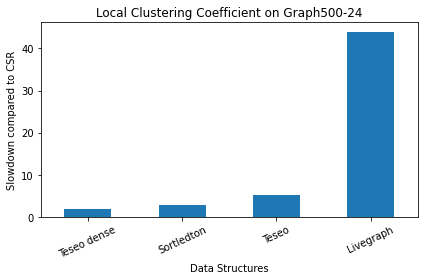

In [9]:
p = data_lcc.plot.bar()

plt.xlabel("Data Structures")
plt.ylabel("Slowdown compared to CSR")
plt.xticks(rotation=25)
plt.title("Local Clustering Coefficient on Graph500-24")
#p.get_legend().remove()
plt.legend().remove()
plt.tight_layout()
plt.savefig(path + "gpm_performance.png")

p

## BFS

In [7]:
data_bfs = data.drop("pagerank_speedup", axis=1)
data_bfs = data_bfs.drop("wcc_speedup", axis=1)
data_bfs = data_bfs.drop("sssp_speedup", axis=1)
data_bfs = data_bfs.drop("lcc_speedup", axis=1)
data_bfs = data_bfs.drop("CSR-LCC")
data_bfs = data_bfs.drop("csr3-lcc-numa")
data_bfs = data_bfs.drop("CSR")
data_bfs = data_bfs.sort_values("bfs_speedup")

data_bfs

Algorithm,bfs_speedup
Library,
LLama,1.206337
Teseo,1.321092
Teseo dense,1.440989
Sortledton,3.028294
Stinger,3.710774
Livegraph,15.874334
G1,26.686480


<AxesSubplot:title={'center':'GAP Benchmark Suite BFS on Graph500-24'}, xlabel='Data Structures', ylabel='Slowdown compared to CSR'>

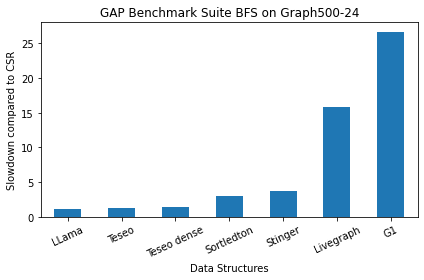

In [8]:
p = data_bfs.plot.bar()

plt.xlabel("Data Structures")
plt.ylabel("Slowdown compared to CSR")
plt.xticks(rotation=25)
plt.title("GAP Benchmark Suite BFS on Graph500-24")
p.get_legend().remove()
plt.tight_layout()
plt.savefig(path + "bfs_performance.png")

p